In [1]:
# Add the parent directory of the current working directory to the Python path at runtime. 
# In order to import modules from the src directory.
import os
import sys 
import openai
from dotenv import load_dotenv, find_dotenv

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

load_dotenv(find_dotenv())
openai.api_key = os.environ["OPENAI_API_KEY"]

BASEPATH = os.environ["BASEPATH"]

In [2]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from src.utils.plotting import convert_size

sns.set_context("paper")

In [3]:
csv_path = os.path.join(BASEPATH, "FINAL/data")
dimensions_file = os.path.join(BASEPATH, csv_path, "neuroscience_dimensions_1999-2023.csv")
dimensions_df = pd.read_csv(dimensions_file)

figure_path = os.path.join(BASEPATH, "FINAL/figures/figure_03")
os.makedirs(figure_path, exist_ok=True)

### Figure 2 Panels

In [4]:
# Define the panel size (width, height) in centimeters
figure_size = [178, 178]

# Convert the panel size to inches
figure_size_inch = convert_size(*figure_size)

# Define the font sizes
fontsize_text = 6
fontsize_ticks = 5

# Define step size for x-axis 
num_clusters = 175
step = 10  # Ensure at least step=1


In [5]:
# Panel A Treemap of the dimensions of neuroscience research
all_dimensions = {'Dimension': [], 'Category': [], 'Count': []}

# Get the count of all dimensions and categories
for dimension_category in dimensions_df.columns:
    category_counts = dimensions_df[dimension_category].sum()
    dimension, category = dimension_category.split('_')
    all_dimensions['Dimension'].append(dimension)
    all_dimensions['Category'].append(category)
    all_dimensions['Count'].append(category_counts)

all_dimensions_df = pd.DataFrame(all_dimensions)
# Get a colorblind friendly palette with 10 colors
palette = sns.color_palette("dark", 10)

# Convert RGB tuples to hex strings
palette_hex = [mcolors.to_hex(color) for color in palette]

# Define color mapping for dimensions
color_map = {
    'Appliedness': palette_hex[0],
    'Methodological Approach': palette_hex[1],
    'Species': palette_hex[2],
    'Spatial Scale': palette_hex[3],
    'Temporal Scale': palette_hex[4],
    'Modality': palette_hex[5],
    'Cognitive Complexity': palette_hex[6],
    'Theory Engagement': palette_hex[7],
    'Theory Scope': palette_hex[8],
    'Interdisciplinarity': palette_hex[9]
}

fig = px.treemap(
    all_dimensions_df,
    path=['Dimension', 'Category'],
    values='Count',
    color='Dimension',
    color_discrete_map=color_map,
    title='Treemap of Neuroscience Research Dimensions',
    hover_data=['Count'],
    labels={'Count': 'Number of Clusters'}
)

# Update the label color
fig.update_traces(textfont_color='white')

# Update layout for better readability
fig.update_layout(
    margin=dict(t=0, l=0, r=0, b=0),
    font=dict(size=18),
)

# Remove title
fig.update_layout(title_text="")

# Save the figure
fig.write_image(os.path.join(figure_path, 'panel_a.svg'), width=1800, height=900)


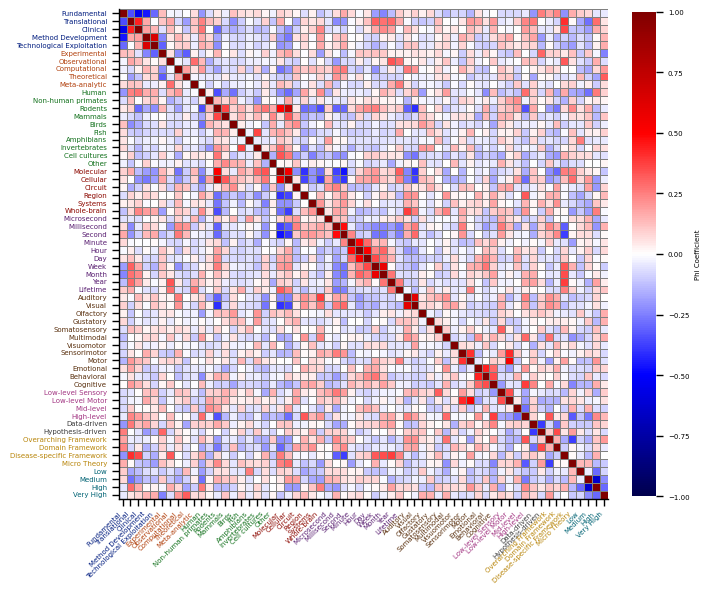

In [6]:
# Panel B Heatmap of the phi coefficient between all category pairs of spatial and temporal scales for all dimensions

# Define the colorbar keyword arguments
cbar_kws = {
    'label': 'Phi Coefficient',
    'shrink': 0.7,
    'aspect': 20,
    'pad': 0.05
}

# Sort dimensions_df by the following dimension order: Appliedness, Methodological Approach, Species, Spatial Scale, Temporal Scale, Modality, Cognitive Complexity, Theory Engagement, Theory Scope, and Interdisciplinarity (not alphabetical)
item_order = ['Appliedness', 'Methodological Approach', 'Species', 'Spatial Scale', 'Temporal Scale', 'Modality', 'Cognitive Complexity', 'Theory Engagement', 'Theory Scope', 'Interdisciplinarity']
new_columns = sorted(dimensions_df.columns, key=lambda x: item_order.index(x.split('_')[0]))
dimensions_df = dimensions_df[new_columns]

# Compute the Phi coefficient matrix for all dimensions
all_dimensions_phi = dimensions_df.corr()

# Extract original labels
original_labels = all_dimensions_phi.columns

# Clean labels by removing the dimension prefix
clean_labels = [label.split('_', 1)[1] for label in original_labels]

# Determine colors based on category type
label_types = [label.split('_', 1)[0] for label in original_labels]
label_colors = [color_map[label_type] for label_type in label_types]
# Initialize the matplotlib figure with constrained_layout to avoid overlaps
plt.figure(figsize=figure_size_inch, constrained_layout=True)

# Plot the heatmap
ax = sns.heatmap(
    all_dimensions_phi,
    cmap='seismic',
    annot=False,
    square=True,
    vmin=-1,
    vmax=1,
    cbar_kws=cbar_kws,
    linewidths=0.5,
    linecolor='gray'
)

# Ensure every cell has a tick and label
ax.set_xticks([i + 0.5 for i in range(len(clean_labels))])
ax.set_yticks([i + 0.5 for i in range(len(clean_labels))])

# Set the tick labels to the cleaned labels
ax.set_xticklabels(clean_labels, fontsize=fontsize_ticks, rotation=45, ha='right')
ax.set_yticklabels(clean_labels, fontsize=fontsize_ticks, rotation=0)

# Apply colors to the tick labels based on their category type
for tick_label, color in zip(ax.get_xticklabels(), label_colors):
    tick_label.set_color(color)

for tick_label, color in zip(ax.get_yticklabels(), label_colors):
    tick_label.set_color(color)

# Remove the top and right spines for a cleaner look
sns.despine(ax=ax)

# Access the colorbar from the heatmap
cbar = ax.collections[0].colorbar

# Set the colorbar label font size
cbar.ax.set_ylabel('Phi Coefficient', fontsize=fontsize_ticks)

# Set the colorbar tick label font size
cbar.ax.tick_params(labelsize=fontsize_ticks)

# Save the heatmap as an SVG file for high quality
plt.savefig(os.path.join(figure_path, 'panel_b.svg'), format='svg', bbox_inches='tight')

# Display the plot
plt.show()

/tmp/ipykernel_7644/1294458112.py:2: RuntimeWarning:

divide by zero encountered in divide



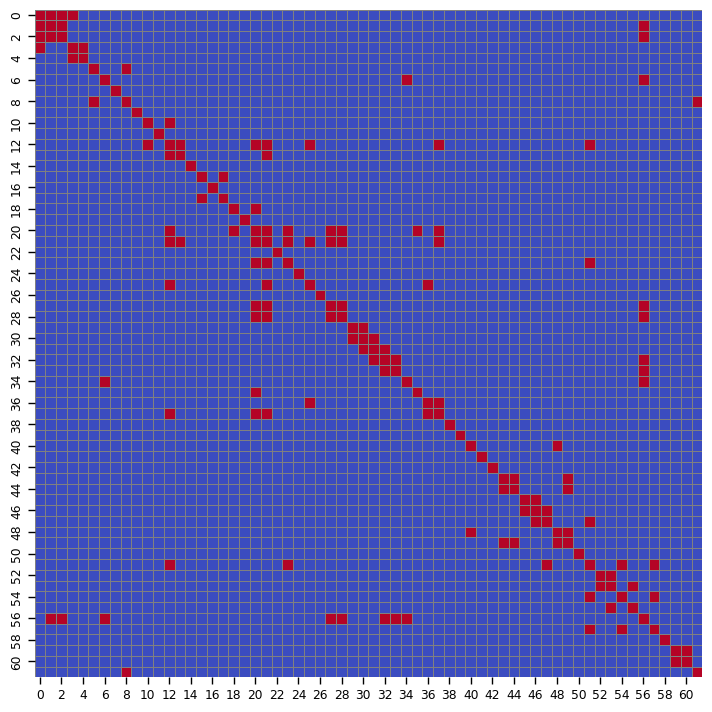

In [7]:
from scipy import stats
t_values = all_dimensions_phi.values * (num_clusters - 2) ** 0.5 / (1 - all_dimensions_phi.values ** 2) ** 0.5

p_values = 2 * (1 - stats.t.cdf(abs(t_values), num_clusters - 1))

#correct for multiple comparisons using bonferroni (ignoring the diagonal)
num_categories = len(clean_labels)
possible_comparisons = num_categories * (num_categories - 1) / 2
p_values_corrected = p_values * possible_comparisons

significant = p_values_corrected < 0.05

# Panel C Heatmap of the significance of the phi coefficient between all category pairs of spatial and temporal scales for all dimensions

# Initialize the matplotlib figure with constrained_layout to avoid overlaps
plt.figure(figsize=figure_size_inch, constrained_layout=True)

# Plot the heatmap
ax = sns.heatmap(
    significant,
    cmap='coolwarm',
    annot=False,
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray'
)

In [ ]:
# Create a set to store unique pairs of significant correlations
unique_significant_pairs = set()
corresponding_p_values = []
corresponding_t_values = []

# Iterate through the significant matrix to find significant correlations
for i in range(significant.shape[0]):
    for j in range(i + 1, significant.shape[1]):
        if significant[i, j]:
            pair = (original_labels[i], original_labels[j])
            unique_significant_pairs.add(pair)

# Print the unique significant correlations
for pair in unique_significant_pairs:
    i_index = original_labels.get_loc(pair[0])
    j_index = original_labels.get_loc(pair[1])
    corresponding_p_values.append(p_values_corrected[i_index, j_index])
    corresponding_t_values.append(t_values[i_index, j_index])
    print(f"{pair[0]} - {pair[1]}, {all_dimensions_phi.loc[pair[0], pair[1]]}")

# Optionally, you can print the p-values and t-values
print("Corresponding p-values:", corresponding_p_values)
print("Corresponding t-values:", corresponding_t_values)

46
Modality_Behavioral - Modality_Cognitive, 0.34817693526508486
20
Spatial Scale_Molecular - Temporal Scale_Second, -0.46401455330549063
51
Cognitive Complexity_High-level - Theory Scope_Micro Theory, -0.3265964623205385
8
Methodological Approach_Theoretical - Interdisciplinarity_Very High, 0.31411276419670964
32
Temporal Scale_Week - Theory Scope_Disease-specific Framework, 0.32164806174531585
23
Spatial Scale_Region - Cognitive Complexity_High-level, 0.32037843042040454
21
Spatial Scale_Cellular - Spatial Scale_Whole-brain, -0.3773203896711463
12
Species_Rodents - Spatial Scale_Cellular, 0.7252547756015161
21
Spatial Scale_Cellular - Modality_Visual, -0.3598972436056235
48
Cognitive Complexity_Low-level Sensory - Cognitive Complexity_Low-level Motor, 0.34692280203740333
40
Modality_Somatosensory - Cognitive Complexity_Low-level Sensory, 0.31425466858202344
51
Cognitive Complexity_High-level - Theory Scope_Overarching Framework, 0.32848073933686533
47
Modality_Cognitive - Cognitive C

In [45]:
corrsponding_p_values

[]

In [50]:
dimension_pair = ('Modality', 'Cognitive Complexity')

degree_of_freedom = num_clusters - 2


print(f'Within {dimension_pair[0]}:')
for i, pair in enumerate(unique_significant_pairs):
    # Are both items in the pair significant relatd to Scale?
    if dimension_pair[0] in pair[0] and dimension_pair[0] in pair[1]:
        print(f"{pair[0].split('_')[1]} - {pair[1].split('_')[1]}, {all_dimensions_phi.loc[pair[0], pair[1]]}, p={corresponding_p_values[i]}, t={corresponding_t_values[i]}")
print('-----------------')

print(f'Within {dimension_pair[1]}:')
for i, pair in enumerate(unique_significant_pairs):
    # Are both items in the pair significant relatd to Scale?
    if dimension_pair[1] in pair[0] and dimension_pair[1] in pair[1]:
        print(f"{pair[0].split('_')[1]} - {pair[1].split('_')[1]}, {all_dimensions_phi.loc[pair[0], pair[1]]}, p={corresponding_p_values[i]}, t={corresponding_t_values[i]}")
print('-----------------')

print(f'Between {dimension_pair[0]} and {dimension_pair[1]}:')
for i, pair in enumerate(unique_significant_pairs):
    # Are both items in the pair significant relatd to Scale?
    if dimension_pair[0] in pair[0] and dimension_pair[1] in pair[1]:
        print(f"{pair[0].split('_')[1]} - {pair[1].split('_')[1]}, {all_dimensions_phi.loc[pair[0], pair[1]]}, p={corresponding_p_values[i]}, t={corresponding_t_values[i]}")
    elif dimension_pair[1] in pair[0] and dimension_pair[0] in pair[1]:
        print(f"{pair[0].split('_')[1]} - {pair[1].split('_')[1]}, {all_dimensions_phi.loc[pair[0], pair[1]]}, p={corresponding_p_values[i]}, t={corresponding_t_values[i]}")


Within Modality:
Behavioral - Cognitive, 0.34817693526508486, p=0.0044074849151083395, t=4.88522691721437
Sensorimotor - Motor, 0.39957110471796775, p=8.079512352510143e-05, t=5.733091194751114
Auditory - Visual, 0.6081686745368807, p=0.0, t=10.077010767246914
Emotional - Behavioral, 0.43013562863753174, p=5.308366546108445e-06, t=6.266919310699755
-----------------
Within Cognitive Complexity:
Low-level Sensory - Low-level Motor, 0.34692280203740333, p=0.004818457947119548, t=4.865217767377858
-----------------
Between Modality and Cognitive Complexity:
Somatosensory - Low-level Sensory, 0.31425466858202344, p=0.04305608813676276, t=4.353951588917587
Cognitive - High-level, 0.3809948597437732, p=0.0003715043107062055, t=5.419996538349546
Motor - Low-level Motor, 0.530517504341954, p=7.935851975560126e-11, t=8.231783064876302
Sensorimotor - Low-level Motor, 0.41424952485828603, p=2.26098960414145e-05, t=5.986399900460627


In [10]:
from mlxtend.frequent_patterns import apriori, association_rules

In [11]:
def display_rule(rules, index):
    
    rule = rules.iloc[index]

    # Extract the rule metrics
    support = rule['support']
    confidence = rule['confidence']
    lift = rule['lift']

    # Extract the antecedent and consequent and vonvert them to a string from a frozenset
    antecedents = sorted(list(rule['antecedents']))
    consequents = sorted(list(rule['consequents']))

    # Rewrite the antecedents and consequents
    antecedents_str = ''
    
    for item in (antecedents):
        dimension, category = item.split('_')
        antecedents_str += f"{category} {dimension} and "

    # remove the last 'and'
    antecedents_str = antecedents_str[:-5]
    antecedents_str += ' implies'

    consequents_str = ''
    for item in (consequents):
        dimension, category = item.split('_')
        consequents_str += f"{category} {dimension} and "

    # remove the last 'and'
    consequents_str = consequents_str[:-5]

    rule = f"{antecedents_str} {consequents_str}"

    

    # Display the rule
    print(f"Rule {index}: {rule}")
    print(f"Support: {support:.2f}")
    print(f"Confidence: {confidence:.2f}")
    print(f"Lift: {lift:.2f}\n")

In [12]:
# Define minimum support threshold
min_support = 0.1  # Adjust based on your dataset size and desired frequency

# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(dimensions_df, min_support=min_support, use_colnames=True)

# Display the frequent itemsets
print(frequent_itemsets.head())

    support                                 itemsets
0  0.811429                (Appliedness_Fundamental)
1  0.554286              (Appliedness_Translational)
2  0.297143                   (Appliedness_Clinical)
3  0.960000   (Methodological Approach_Experimental)
4  0.457143  (Methodological Approach_Computational)


In [13]:
# Define minimum confidence threshold
min_confidence = 0.7  # Adjust based on desired rule strength

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

# Display the rules
print(rules.head())


                               antecedents  \
0   (Methodological Approach_Experimental)   
1                (Appliedness_Fundamental)   
2  (Methodological Approach_Computational)   
3                          (Species_Human)   
4             (Species_Non-human primates)   

                              consequents  antecedent support  \
0               (Appliedness_Fundamental)            0.960000   
1  (Methodological Approach_Experimental)            0.811429   
2               (Appliedness_Fundamental)            0.457143   
3               (Appliedness_Fundamental)            0.714286   
4               (Appliedness_Fundamental)            0.325714   

   consequent support   support  confidence      lift  representativity  \
0            0.811429  0.788571    0.821429  1.012324               1.0   
1            0.960000  0.788571    0.971831  1.012324               1.0   
2            0.811429  0.365714    0.800000  0.985915               1.0   
3            0.811429  0.542857 

In [14]:
# Define minimum lift threshold
min_lift = 2  # Lift > 1 indicates a positive association

# Filter rules with lift greater than min_lift
filtered_rules = rules[rules['lift'] > min_lift]

# Filter rules with no more than 2 antecedents
filtered_rules = filtered_rules[filtered_rules['antecedents'].apply(len) <= 1]

# Sort the rules by confidence or lift
filtered_rules = filtered_rules.sort_values(by='lift', ascending=False)

# Display all filtered rules
for i in range(len(filtered_rules)):
    display_rule(filtered_rules, i)
    print("-------------------")


Rule 0: Auditory Modality implies Visual Modality and Human Species
Support: 0.14
Confidence: 0.73
Lift: 3.35

-------------------
Rule 1: Auditory Modality implies Visual Modality
Support: 0.15
Confidence: 0.82
Lift: 3.11

-------------------
Rule 2: Auditory Modality implies Experimental Methodological Approach and Visual Modality
Support: 0.15
Confidence: 0.79
Lift: 3.06

-------------------
Rule 3: Month Temporal Scale implies Week Temporal Scale
Support: 0.16
Confidence: 0.74
Lift: 2.93

-------------------
Rule 4: Month Temporal Scale implies Experimental Methodological Approach and Week Temporal Scale
Support: 0.16
Confidence: 0.74
Lift: 2.93

-------------------
Rule 5: Year Temporal Scale implies High Interdisciplinarity and Disease-specific Framework Theory Scope
Support: 0.14
Confidence: 0.71
Lift: 2.38

-------------------
Rule 6: Behavioral Modality implies Experimental Methodological Approach and Cognitive Modality
Support: 0.10
Confidence: 0.75
Lift: 2.30

--------------

In [15]:
antecedents = frozenset({'Appliedness_Clinical'})

#print(f"Antecedents: {antecedents}")
#print(rules[(rules['antecedents'] == antecedents) & (rules['lift'] > 1.5)])

consequents_set  = set()

for index, row in rules.iterrows():
    if (row['antecedents'] == antecedents) and (row['lift'] > 1.5):
        # convert the frozenset to a set
        consequents_set.update(set(row['consequents']))
        is_identical = consequents_set.issubset(row['consequents'])


# convert consequents_set to a frozenset
consequents = frozenset(consequents_set)

print(f"Consequents: {consequents}")

Consequents: frozenset({'Theory Engagement_Data-driven', 'Methodological Approach_Experimental', 'Species_Human', 'Appliedness_Translational'})


In [16]:
import numpy as np
from prettytable import PrettyTable


selected_dimension = 'Methodological Approach'
select_index = [i for i, label in enumerate(original_labels) if selected_dimension in label]
select_labels = [label for label in original_labels if selected_dimension in label]

selected_dim_phi = all_dimensions_phi.iloc[select_index, select_index]

indices = np.meshgrid(range(len(selected_dim_phi)), range(len(selected_dim_phi)))

mask = np.triu(np.ones(selected_dim_phi.shape), k=1).astype(bool)
indices = np.array(indices).T[mask]

corr_triu = selected_dim_phi.values[mask]

# Create a table to display the phi coefficients below -0.2 
table = PrettyTable()
table.field_names = ["Dimension 1", "Dimension 2", "Phi Coefficient"]

for index, (i, j) in enumerate(indices):
    if corr_triu[index] < -0.25:
        table.add_row([select_labels[i], select_labels[j], corr_triu[index]])


# sort the table by the phi coefficient in ascending order
table.sortby = "Phi Coefficient"
table.reversesort = False   

print(table)


+--------------------------------------+-------------------------------------+----------------------+
|             Dimension 1              |             Dimension 2             |   Phi Coefficient    |
+--------------------------------------+-------------------------------------+----------------------+
| Methodological Approach_Experimental | Methodological Approach_Theoretical | -0.31506301890630223 |
+--------------------------------------+-------------------------------------+----------------------+


In [17]:
import numpy as np
from prettytable import PrettyTable


selected_dimension = 'Methodological Approach'
select_index = [i for i, label in enumerate(original_labels) if selected_dimension in label]
select_labels = [label for label in original_labels if selected_dimension in label]

selected_dim_phi = all_dimensions_phi.iloc[select_index, select_index]

indices = np.meshgrid(range(len(selected_dim_phi)), range(len(selected_dim_phi)))

mask = np.triu(np.ones(selected_dim_phi.shape), k=1).astype(bool)
indices = np.array(indices).T[mask]

corr_triu = selected_dim_phi.values[mask]

# Create a table to display the phi coefficients below -0.2 
table = PrettyTable()
table.field_names = ["Dimension 1", "Dimension 2", "Phi Coefficient"]

for index, (i, j) in enumerate(indices):
    if corr_triu[index] > 0.25:
        table.add_row([select_labels[i], select_labels[j], corr_triu[index]])


# sort the table by the phi coefficient in ascending order
table.sortby = "Phi Coefficient"
table.reversesort = True  

print(table)


+---------------------------------------+---------------------------------------+--------------------+
|              Dimension 1              |              Dimension 2              |  Phi Coefficient   |
+---------------------------------------+---------------------------------------+--------------------+
| Methodological Approach_Observational | Methodological Approach_Meta-analytic | 0.2855938886394045 |
+---------------------------------------+---------------------------------------+--------------------+


In [18]:
# count number of items that are visual but not auditory
visual = dimensions_df[dimensions_df['Modality_Visual'] == 1].shape[0]
auditory = dimensions_df[dimensions_df['Modality_Auditory'] == 1].shape[0]
both = dimensions_df[(dimensions_df['Modality_Visual'] == 0) & (dimensions_df['Modality_Auditory'] == 1)].shape[0]
both

6